In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import os
from sklearn.metrics import (roc_curve, accuracy_score, log_loss, 
                            balanced_accuracy_score, confusion_matrix, 
                            roc_auc_score, make_scorer, precision_score, recall_score,
                            average_precision_score, precision_recall_curve, roc_curve)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [3]:
# choose from v20210909(med administration) and v20210921_labs_vitals_only(no meds), and v20210930 (med orders) 

site='HUF'
# results_dir = '/home/prash/results/madrid/v20211018/HUF/split-by=patient_id/collapsed_features_dynamic_input_output'
clf_train_test_split_dir = '/home/prash/datasets/v20211018/%s/split-by=patient_id/collapsed_features_dynamic_input_output/classifier_train_test_split'%site

suffix='10_6_vitals_only'
eval_times='10_6'
results_dir = '/home/prash/results/madrid/v20211018/%s/split-by=patient_id/collapsed_features_dynamic_input_output/CustomTimes_%s/'%(site, eval_times)
huf_df = pd.read_pickle(os.path.join(results_dir, "alarm_stats_7D.csv"))
# huf_df = pd.read_pickle(os.path.join(results_dir, "alarm_stats_7D_HIL_trained_on_HUF.csv"))
# huf_df = pd.read_pickle(os.path.join(results_dir, "alarm_stats_7D_HUF_trained_on_HIL.csv"))

# rnn_results_dir = '/home/prash/results/madrid/v20210930/HUF/split-by=patient_id/features_per_timestep'
# huf_rnn_df = pd.read_pickle(os.path.join(rnn_results_dir, "rnn_alarm_stats.csv"))
# huf_df = pd.concat([huf_df, huf_rnn_df])


# y_train_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_train.csv.gz'))
# y_valid_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_valid.csv.gz'))
# y_test_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_test.csv.gz'))


y_train_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_trainCustomTimes_%s.csv.gz'%suffix))
y_valid_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_validCustomTimes_%s.csv.gz'%suffix))
y_test_df = pd.read_csv(os.path.join(clf_train_test_split_dir, 'y_testCustomTimes_%s.csv.gz'%suffix))

y_train = np.ravel(y_train_df['clinical_deterioration_outcome'].values)
y_valid = np.ravel(y_valid_df['clinical_deterioration_outcome'].values)
y_test = np.ravel(y_test_df['clinical_deterioration_outcome'].values)

/home/prash/.conda/envs/madrid_data_prep/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


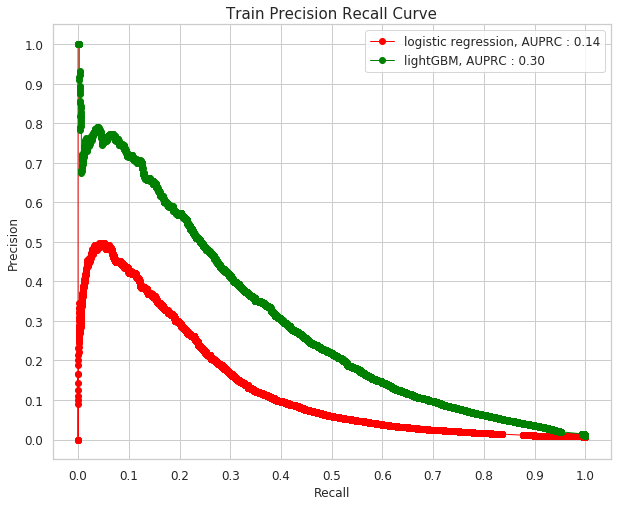

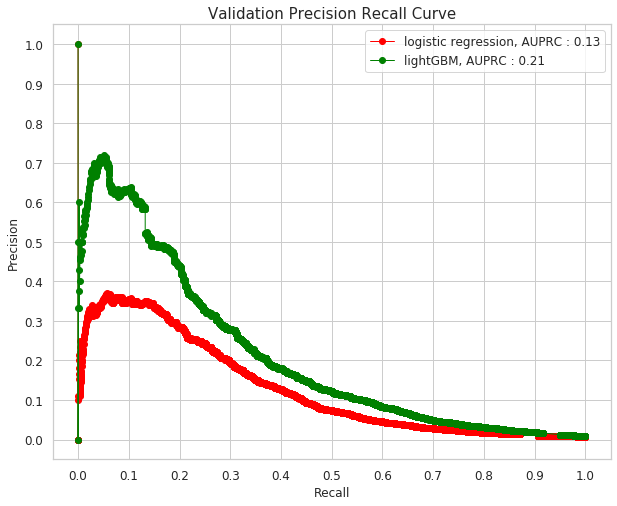

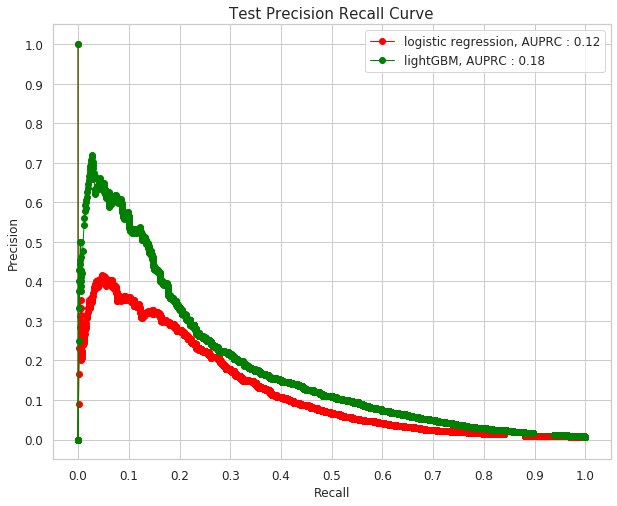

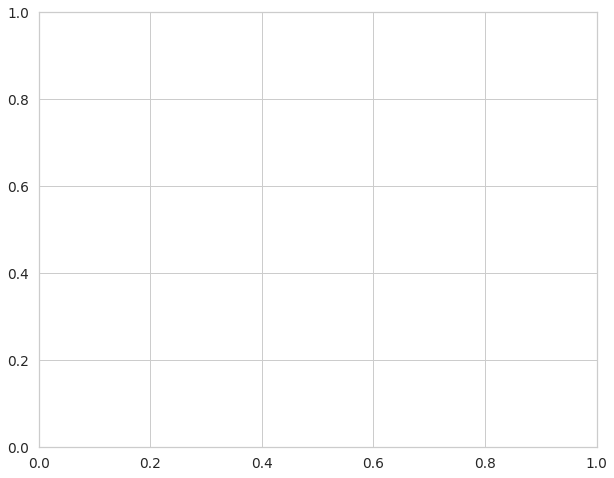

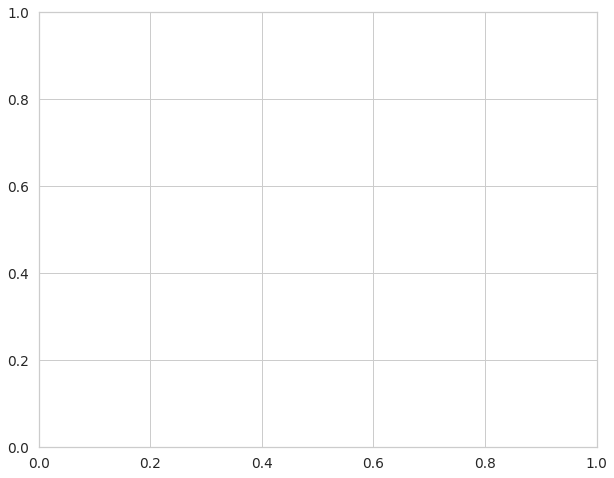

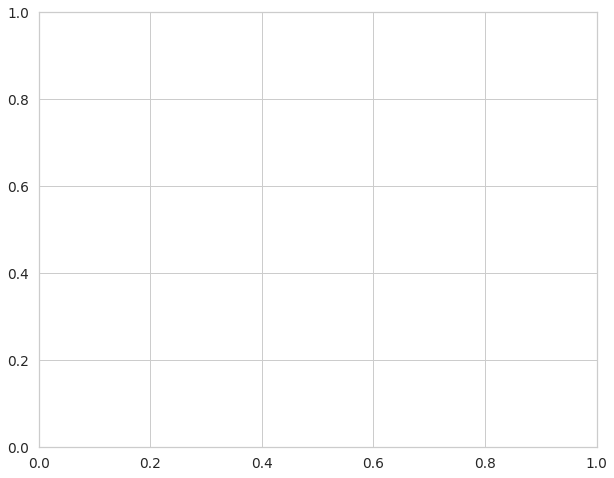

In [7]:
full_ds_df = pd.read_pickle(os.path.join(results_dir, "performance_of_best_clfs.pkl"))
# full_ds_df = pd.read_pickle(os.path.join(results_dir, "performance_of_best_clfs_HIL_trained_on_HUF.pkl"))
# full_ds_df = pd.read_pickle(os.path.join(results_dir, "performance_of_best_clfs_HUF_trained_on_HIL.pkl"))

# rnn_full_ds_df = pd.read_pickle(os.path.join(rnn_results_dir, "performance_of_best_rnn.pkl"))
# full_ds_df = pd.concat([full_ds_df, rnn_full_ds_df])


models_dict = {
    'logistic regression' : {'dirname':'skorch_logistic_regression', 
                                       'model_color' : 'r', 
                                       'model_marker' : 's'},
             'lightGBM' : {'dirname': 'lightGBM',
                                'model_color' : 'g',
                                'model_marker' : 'o'},
#              'MLP 1 layer' : {'dirname': 'skorch_mlp',
#                             'model_color' : 'k',
#                             'model_marker' : 'x'},
#              'MLP 2 layer' : {'dirname': 'skorch_mlp',
#                             'model_color' : 'r',
#                             'model_marker' : 'x'},
#               'MEWS' : {'dirname' : None,
#                                'model_color' : 'm',
#                               'model_marker' : '.'},
#              'GRU-RNN' : {'dirname':'rnn_per_tstep', 
#                           'model_color' : 'k', 
#                           'model_marker' : 's'},
              }


# models_dict = {
#               'lightGBM' : {'dirname': 'lightGBM',
#                                 'model_color' : 'm',
#                                 'model_marker' : 'o'},
#               'MLP 1 layer (BCE + thr search)' : {'dirname' : 'skorch_mlp/CustomTimes_10_6',
#                                                    'model_color' : 'k',
#                                                    'model_marker' : '^'},
#               'MLP 1 layer (Hinge Bound)' : {'dirname' : 'skorch_mlp/CustomTimes_10_6',
#                                              'model_color' : 'g',
#                                              'model_marker' : '^'},
#               'MLP 1 layer (Sigmoid Bound)' : {'dirname' : 'skorch_mlp/CustomTimes_10_6',
#                                                'model_color' : 'r',
#                                                'model_marker' : '^'},
#               }


pr_f_tr, pr_axs_tr = plt.subplots(1, 1, figsize=(10, 8))
pr_f_va, pr_axs_va = plt.subplots(1, 1, figsize=(10, 8))
pr_f_te, pr_axs_te = plt.subplots(1, 1, figsize=(10, 8))
auc_f_tr, auc_axs_tr = plt.subplots(1, 1, figsize=(10, 8))
auc_f_va, auc_axs_va = plt.subplots(1, 1, figsize=(10, 8))
auc_f_te, auc_axs_te = plt.subplots(1, 1, figsize=(10, 8))

for model_name in models_dict.keys():
    
    model_ind = full_ds_df['model']==model_name
    y_train_proba_vals = full_ds_df.loc[model_ind, 'best_model_train_pred_probas'].values[0]
    y_valid_proba_vals = full_ds_df.loc[model_ind, 'best_model_valid_pred_probas'].values[0]
    y_test_proba_vals = full_ds_df.loc[model_ind, 'best_model_test_pred_probas'].values[0]
    
    
    best_model_auprc_train = average_precision_score(y_train, y_train_proba_vals)
    best_model_auprc_valid = average_precision_score(y_valid, y_valid_proba_vals)
    best_model_auprc_test = average_precision_score(y_test, y_test_proba_vals)

    best_model_auroc_train = roc_auc_score(y_train, y_train_proba_vals)
    best_model_auroc_valid = roc_auc_score(y_valid, y_valid_proba_vals)
    best_model_auroc_test = roc_auc_score(y_test, y_test_proba_vals)
    
    
    # create the precision recall plot
    precs_train, recs_train, thresholds_train = precision_recall_curve(y_train, y_train_proba_vals)
    precs_valid, recs_valid, thresholds_valid = precision_recall_curve(y_valid, y_valid_proba_vals)
    precs_test, recs_test, thresholds_test = precision_recall_curve(y_test, y_test_proba_vals)  

#     fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba_vals)
#     fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_proba_vals)
#     fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba_vals)

    linewidth=1.0
    pr_axs_tr.plot(recs_train, precs_train, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_train), linewidth=linewidth)

    pr_axs_va.plot(recs_valid, precs_valid, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_valid), linewidth=linewidth)

    pr_axs_te.plot(recs_test, precs_test, models_dict[model_name]['model_color']+'-o', label = '%s, AUPRC : %.2f'%(model_name, best_model_auprc_test), linewidth=linewidth)

#     auc_axs_tr.plot(fpr_train, tpr_train, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_train), linewidth=linewidth)

#     auc_axs_va.plot(fpr_valid, tpr_valid, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_valid), linewidth=linewidth)

#     auc_axs_te.plot(fpr_test, tpr_test, models_dict[model_name]['model_color']+'-o', label = '%s, AUROC : %.2f'%(model_name, best_model_auroc_test), linewidth=linewidth)


ticks = np.arange(0.0, 1.1, 0.1)
ticklabels = ['%.1f'%x for x in ticks]
lims = [-0.05, 1.05]
fontsize = 12
for (ax, ax_title) in [(pr_axs_tr, 'Train Precision Recall Curve'), 
                       (pr_axs_va, 'Validation Precision Recall Curve'),
                       (pr_axs_te, 'Test Precision Recall Curve')]:
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=fontsize)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels, fontsize=fontsize)
    ax.set_title(ax_title, fontsize = fontsize+3)
    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Recall', fontsize=fontsize)
    ax.set_ylabel('Precision', fontsize=fontsize)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True)

# pr_f_tr.savefig('pr_curve_train_with_med_orders.png', bbox_inches='tight', pad_inches=0)
# pr_f_va.savefig('pr_curve_valid_with_med_orders.png', bbox_inches='tight', pad_inches=0)
# pr_f_te.savefig('pr_curve_test_with_med_orders.png', bbox_inches='tight', pad_inches=0)

# for (ax, ax_title) in [(auc_axs_tr, 'Train ROC Curve'), 
#                        (auc_axs_va, 'Validation ROC Curve'),
#                        (auc_axs_te, 'Test ROC Curve')]:
#     ax.set_xticks(ticks)
#     ax.set_xticklabels(ticklabels, fontsize=fontsize)
#     ax.set_yticks(ticks)
#     ax.set_yticklabels(ticklabels, fontsize=fontsize)
#     ax.set_title(ax_title, fontsize = fontsize+3)
#     ax.legend(fontsize=fontsize)
#     ax.set_xlabel('FPR', fontsize=fontsize)
#     ax.set_ylabel('TPR', fontsize=fontsize)
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.grid(True)

# auc_f_tr.savefig('roc_curve_train_with_med_orders.png', bbox_inches='tight', pad_inches=0)
# auc_f_va.savefig('roc_curve_valid_with_med_orders.png', bbox_inches='tight', pad_inches=0)
# auc_f_te.savefig('roc_curve_test_with_med_orders.png', bbox_inches='tight', pad_inches=0)    

# print('Saved pr, roc curves on train, valid, test to : %s'%args.output_dir)

In [25]:
valid_tp_per_thresh = huf_df.query("model == 'lightGBM' and split == 'valid'")['TP_arr'].values[0].sum(axis=0)
valid_fp_per_thresh = huf_df.query("model == 'lightGBM' and split == 'valid'")['FP_arr'].values[0].sum(axis=0)
valid_fn_per_thresh = huf_df.query("model == 'lightGBM' and split == 'valid'")['FN_arr'].values[0].sum(axis=0)

test_tp_per_thresh = huf_df.query("model == 'lightGBM' and split == 'test'")['TP_arr'].values[0].sum(axis=0)
test_fp_per_thresh = huf_df.query("model == 'lightGBM' and split == 'test'")['FP_arr'].values[0].sum(axis=0)
test_fn_per_thresh = huf_df.query("model == 'lightGBM' and split == 'test'")['FN_arr'].values[0].sum(axis=0)

thr_grid = huf_df.query("model == 'lightGBM' and split == 'valid'")['threshold_grid'].values[0]

valid_precision_per_thresh = valid_tp_per_thresh/(valid_tp_per_thresh+valid_fp_per_thresh)
valid_recall_per_thresh = valid_tp_per_thresh/(valid_tp_per_thresh+valid_fn_per_thresh)

test_precision_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fp_per_thresh)
test_recall_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fn_per_thresh)

keep_inds = valid_precision_per_thresh>0.25
max_r_at_p_valid = max(valid_recall_per_thresh[keep_inds])
chosen_thresh_ind = np.flatnonzero((keep_inds)&(valid_recall_per_thresh>max_r_at_p_valid-1e-10))[-1]
chosen_thresh = thr_grid[chosen_thresh_ind]

chosen_thresh_dict = {'precision_valid' : valid_precision_per_thresh[chosen_thresh_ind],
                     'precision_test' : test_precision_per_thresh[chosen_thresh_ind],
                     'recall_valid' : valid_recall_per_thresh[chosen_thresh_ind],
                     'recall_test' : test_recall_per_thresh[chosen_thresh_ind]}
print(chosen_thresh_dict)
print(chosen_thresh)

{'precision_valid': 0.25198637911464244, 'precision_test': 0.2157244964262508, 'recall_valid': 0.3229090909090909, 'recall_test': 0.2999096657633243}
0.8752648312695707


<ipython-input-25-85ec0a492d9b>:14: RuntimeWarning: invalid value encountered in true_divide
  test_precision_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fp_per_thresh)


In [26]:
keep_inds = (thr_grid>=0.8925)&(thr_grid<0.8926)
print('Valid precision at chosen thresh = %.2f'%valid_precision_per_thresh[keep_inds])
print('Valid recall at chosen thresh = %.2f'%valid_recall_per_thresh[keep_inds])

print('Test precision at chosen thresh = %.2f'%test_precision_per_thresh[keep_inds])
print('Test recall at chosen thresh = %.2f'%test_recall_per_thresh[keep_inds])

Valid precision at chosen thresh = 0.30
Valid recall at chosen thresh = 0.28
Test precision at chosen thresh = 0.26
Test recall at chosen thresh = 0.25


In [9]:
valid_tp_per_thresh = huf_df.query("model == 'logistic regression' and split == 'valid'")['TP_arr'].values[0].sum(axis=0)
valid_fp_per_thresh = huf_df.query("model == 'logistic regression' and split == 'valid'")['FP_arr'].values[0].sum(axis=0)
valid_fn_per_thresh = huf_df.query("model == 'logistic regression' and split == 'valid'")['FN_arr'].values[0].sum(axis=0)

test_tp_per_thresh = huf_df.query("model == 'logistic regression' and split == 'test'")['TP_arr'].values[0].sum(axis=0)
test_fp_per_thresh = huf_df.query("model == 'logistic regression' and split == 'test'")['FP_arr'].values[0].sum(axis=0)
test_fn_per_thresh = huf_df.query("model == 'logistic regression' and split == 'test'")['FN_arr'].values[0].sum(axis=0)

thr_grid = huf_df.query("model == 'logistic regression' and split == 'valid'")['threshold_grid'].values[0]

valid_precision_per_thresh = valid_tp_per_thresh/(valid_tp_per_thresh+valid_fp_per_thresh)
valid_recall_per_thresh = valid_tp_per_thresh/(valid_tp_per_thresh+valid_fn_per_thresh)

test_precision_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fp_per_thresh)
test_recall_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fn_per_thresh)

keep_inds = valid_precision_per_thresh>0.25
max_r_at_p_valid = max(valid_recall_per_thresh[keep_inds])
chosen_thresh_ind = np.flatnonzero((keep_inds)&(valid_recall_per_thresh>max_r_at_p_valid-1e-10))[-1]
chosen_thresh = thr_grid[chosen_thresh_ind]

chosen_thresh_dict = {'precision_valid' : valid_precision_per_thresh[chosen_thresh_ind],
                     'precision_test' : test_precision_per_thresh[chosen_thresh_ind],
                     'recall_valid' : valid_recall_per_thresh[chosen_thresh_ind],
                     'recall_test' : test_recall_per_thresh[chosen_thresh_ind]}
print(chosen_thresh_dict)
print(chosen_thresh)

{'precision_valid': 0.25195007800312014, 'precision_test': 0.22825150732127478, 'recall_valid': 0.2349090909090909, 'recall_test': 0.23938572719060525}
0.08366207384612516


<ipython-input-9-1ea00f4ef161>:14: RuntimeWarning: invalid value encountered in true_divide
  test_precision_per_thresh = test_tp_per_thresh/(test_tp_per_thresh+test_fp_per_thresh)


In [24]:
keep_inds = (thr_grid>=0.1166)&(thr_grid<0.1167)
print('Valid precision at chosen thresh = %.2f'%valid_precision_per_thresh[keep_inds])
print('Valid recall at chosen thresh = %.2f'%valid_recall_per_thresh[keep_inds])

print('Test precision at chosen thresh = %.2f'%test_precision_per_thresh[keep_inds])
print('Test recall at chosen thresh = %.2f'%test_recall_per_thresh[keep_inds])

Valid precision at chosen thresh = 0.30
Valid recall at chosen thresh = 0.18
Test precision at chosen thresh = 0.29
Test recall at chosen thresh = 0.19


In [11]:
W = 55   # number of weeks
G = 1000 # number of thresholds

In [10]:
color_map = {
#     'MEWS':'m',
    'logistic regression': 'b',
    'lightGBM': 'r',
#     'MLP 2 layer': 'k',
#     'MLP 1 layer' : 'k'
#     'GRU-RNN' : 'k'
    }


# color_map = {'MLP 1 layer (BCE + thr search)' : 'k',
#               'MLP 1 layer (Hinge Bound)' : 'g',
#               'MLP 1 layer (Sigmoid Bound)' : 'r'}

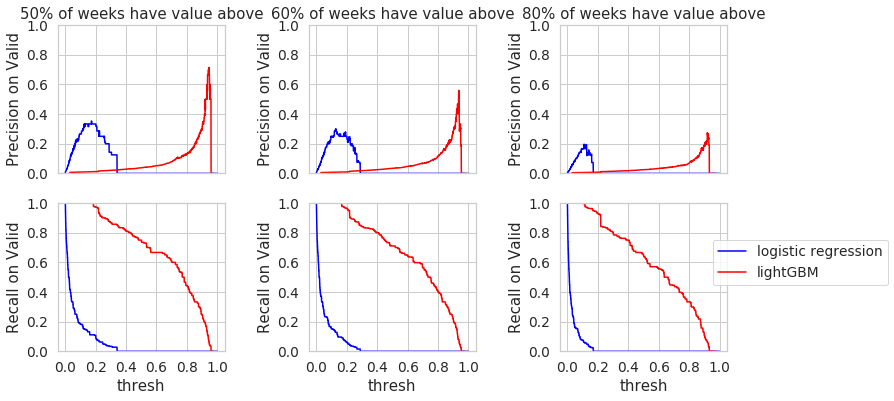

In [11]:
prec_ymax = 1.0;
recall_ymax = 1.0;
ticks = [0.0, .2, .4, .6, .8, 1.0]

f, axgrid = plt.subplots(
    nrows=2, ncols=3, sharex=True, sharey=False,
    figsize=(12, 6));

prec_and_recall_by_model = dict()

for model in models_dict.keys():
    
    for split in ['valid', 'test']:
        model_df = huf_df.query("model == '%s' and split == '%s'" % (model,split)).reset_index().copy()
    
        thresh_G = model_df['threshold_grid'].values[0]
        minval = thresh_G.min()
        maxval = thresh_G.max()
#         thresh_G = (thresh_G - minval) / (maxval - minval) # ensure thresholds go from 0 to 1 for clean viz
    
        TP_WG = model_df['TP_arr'].values[0]
        FP_WG = model_df['FP_arr'].values[0]
        TN_WG = model_df['TN_arr'].values[0]
        FN_WG = model_df['FN_arr'].values[0]

        prec_WG = TP_WG / (1e-10 + TP_WG + FP_WG)
        recall_WG = TP_WG / (1e-10 + TP_WG + FN_WG)
    
        if split == 'test':
            prec_and_recall_by_model[model]['test_thresh'] = thresh_G
            prec_and_recall_by_model[model]['test_prec'] = prec_WG.copy()
            prec_and_recall_by_model[model]['test_recall'] = recall_WG.copy()
        else:
            prec_and_recall_by_model[model] = dict(
                thresh=thresh_G, prec=prec_WG.copy(), recall=recall_WG.copy())
        
        if split == 'valid':
            for pp, perc in enumerate([50, 60, 80]):
                if pp == 2:
                    label = str(model).replace("_", " ")
                else:
                    label = ''
                axgrid[0,pp].plot(
                    thresh_G, np.percentile(prec_WG, 100-perc, axis=0),
                    label=label,
                    color=color_map[model]);
                axgrid[0,pp].set_ylabel('Precision on Valid')
                axgrid[0,pp].set_xticks(ticks)
                axgrid[0,pp].set_yticks(ticks)
                axgrid[0,pp].set_ylim([0, prec_ymax]);
                axgrid[0,pp].set_title("%.0f%% of weeks have value above" % perc)

                axgrid[1,pp].plot(
                    thresh_G, np.percentile(recall_WG, 100-perc, axis=0),
                    label=label,
                    color=color_map[model]);
                axgrid[1,pp].set_ylabel('Recall on Valid')
                axgrid[1,pp].set_xlabel('thresh')

                axgrid[1,pp].set_xticks(ticks)
                axgrid[1,pp].set_yticks(ticks)
                axgrid[1,pp].set_ylim([0, recall_ymax]);
                
        plt.legend(bbox_to_anchor=(2.0, 0.8));
        
plt.subplots_adjust(wspace=0.5);
# f.savefig('precision_recall_weeks_across_thresholds_HUF.pdf', bbox_inches='tight', pad_inches=0)

## Select ideal threshold for each possible desired precision

Selection strategy:

On the VALIDATION set, compute the precision and recall that MAJORITY of all 1-week intervals reach.

Try each possible desired precision from 0.2, 0.19, 0.18, 0.17, .... down to 0.0

At each one, either:

* Determine that it is INFEASIBLE : no threshold will reach it
* Determine that it is FEASIBLE and select among all thresholds that reach it, the one that maximizes recall 

We'll then be able to make plots showing all FEASIBLE thresholds

In [12]:
ideal_precision = 0.25#0.5
step = 0.002
tolerated_precisions = np.arange(0.0, ideal_precision+step, step)[::-1]

target_percentile = 60 # majority is defined as 80% of all weeks

row_dict_list = list()

def summarize(a_WG):
    return np.percentile(a_WG, 100 - target_percentile, axis=0)

for model in models_dict.keys():
    thresh_G = prec_and_recall_by_model[model]['thresh']
    prec_WG   = prec_and_recall_by_model[model]['prec']
    recall_WG = prec_and_recall_by_model[model]['recall']

    prec_at_target_perc_G = summarize(prec_WG)
    recall_at_target_perc_G = summarize(recall_WG)

    best_id = None
    for cur_eps in tolerated_precisions:

        mask_G = prec_at_target_perc_G >= cur_eps
        if np.sum(mask_G) > 0.0:
            best_id = np.argmax(recall_at_target_perc_G[mask_G])
            best_thresh = thresh_G[mask_G][best_id]
            best_precision = prec_at_target_perc_G[mask_G][best_id]
            best_recall = recall_at_target_perc_G[mask_G][best_id]
            row_dict_list.append(
                dict(
                    model=model, split='valid',
                    desired_eps=cur_eps,
                    thresh=best_thresh,
                    prec=best_precision,
                    recall=best_recall,
                    target_percentile=target_percentile,
                ))

target_perf_df = pd.DataFrame(row_dict_list)
print(target_perf_df.to_string(index=False, float_format='%.3f'))

               model  split  desired_eps  thresh  prec  recall  target_percentile
 logistic regression  valid        0.250   0.117 0.256   0.143                 60
 logistic regression  valid        0.248   0.096 0.250   0.162                 60
 logistic regression  valid        0.246   0.096 0.250   0.162                 60
 logistic regression  valid        0.244   0.096 0.250   0.162                 60
 logistic regression  valid        0.242   0.096 0.242   0.162                 60
 logistic regression  valid        0.240   0.096 0.242   0.162                 60
 logistic regression  valid        0.238   0.096 0.242   0.162                 60
 logistic regression  valid        0.236   0.096 0.242   0.162                 60
 logistic regression  valid        0.234   0.096 0.242   0.162                 60
 logistic regression  valid        0.232   0.096 0.242   0.162                 60
 logistic regression  valid        0.230   0.096 0.242   0.162                 60
 logistic regres

## Visualize the performance at the chosen thresholds


In [63]:
prec_and_recall_by_model[model]['thresh'].shape

(4723,)

In [13]:
row_dict_list = list()

# Always put the target percentile (used to select thresholds) first
for percentile_to_try in [60.0, 50.0, 40.0]:

    def assess_perf_at_fixed_thresh(thr, thresh_G, prec_WG, recall_WG, perc):
        prec_G = np.percentile(prec_WG, 100 - perc, axis=0)
        recall_G = np.percentile(recall_WG, 100 - perc, axis=0)
        gg = np.searchsorted(thresh_G, thr)
        return dict(
            prec=prec_G[gg],
            recall=recall_G[gg],
            )
    
    for model in models_dict.keys():
        a_df = target_perf_df.query(
            "model == '%s'" % (model))
        
        thresh_G = prec_and_recall_by_model[model]['thresh']
        cur_eps_list = a_df['desired_eps'].unique()
        for cur_eps in cur_eps_list:
            b_df = a_df.query("desired_eps == %s" % cur_eps)
            assert b_df.shape[0] == 1
            thresh = float(b_df['thresh'].values[0])

            valid_row_dict = dict(
                    model=model, split='valid',
                    desired_eps=cur_eps,
                    thresh=thresh,
                    target_percentile=percentile_to_try,
                    )
            valid_row_dict.update(
                assess_perf_at_fixed_thresh(
                    thresh, thresh_G,
                    prec_and_recall_by_model[model]['prec'],
                    prec_and_recall_by_model[model]['recall'],
                    percentile_to_try))
            row_dict_list.append(valid_row_dict)
            
            test_row_dict = dict(
                    model=model, split='test',
                    desired_eps=cur_eps,
                    thresh=thresh,
                    target_percentile=percentile_to_try,
                    )
            test_row_dict.update(
                assess_perf_at_fixed_thresh(
                    thresh, thresh_G,
                    prec_and_recall_by_model[model]['test_prec'],
                    prec_and_recall_by_model[model]['test_recall'],
                    percentile_to_try))
            row_dict_list.append(test_row_dict)

all_perf_df = pd.DataFrame(row_dict_list)
print(all_perf_df.to_string(index=False, float_format='%.3f'))

               model  split  desired_eps  thresh  target_percentile  prec  recall
 logistic regression  valid        0.250   0.117             60.000 0.256   0.143
 logistic regression   test        0.250   0.117             60.000 0.270   0.147
 logistic regression  valid        0.248   0.096             60.000 0.250   0.162
 logistic regression   test        0.248   0.096             60.000 0.244   0.185
 logistic regression  valid        0.246   0.096             60.000 0.250   0.162
 logistic regression   test        0.246   0.096             60.000 0.244   0.185
 logistic regression  valid        0.244   0.096             60.000 0.250   0.162
 logistic regression   test        0.244   0.096             60.000 0.244   0.185
 logistic regression  valid        0.242   0.096             60.000 0.242   0.162
 logistic regression   test        0.242   0.096             60.000 0.244   0.185
 logistic regression  valid        0.240   0.096             60.000 0.242   0.162
 logistic regres

                   model  split  desired_eps    thresh  target_percentile  \
0    logistic regression  valid        0.250  0.116560               60.0   
2    logistic regression  valid        0.248  0.095661               60.0   
4    logistic regression  valid        0.246  0.095661               60.0   
6    logistic regression  valid        0.244  0.095661               60.0   
8    logistic regression  valid        0.242  0.095561               60.0   
..                   ...    ...          ...       ...                ...   
242  logistic regression  valid        0.008  0.002568               60.0   
244  logistic regression  valid        0.006  0.000468               60.0   
246  logistic regression  valid        0.004  0.000168               60.0   
248  logistic regression  valid        0.002  0.000168               60.0   
250  logistic regression  valid        0.000  0.000168               60.0   

         prec    recall  
0    0.255556  0.142857  
2    0.250000  0.161538

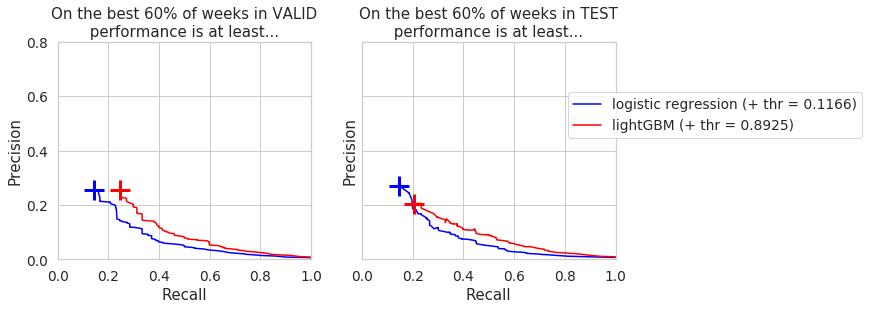

In [18]:
#precision_ymax = 1.0
#for target_percentile in [80.0, 60., 40., 20, 0]:

precision_ymax = 0.8
for target_percentile in [60.0]:
    f, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharex=True, sharey=True)

    for ss, split in enumerate(['valid', 'test']):
        ax = axgrid[ss]
        ax.set_title("On the best %.0f%% of weeks in %s\n performance is at least... " % (
            target_percentile, split.upper()));

        for model in models_dict.keys():
            row_df = all_perf_df.query(
                "model == '%s' and split == '%s' and target_percentile == %f" % (model, split, target_percentile))
            assert row_df.shape[0] >= 1
            
#             precs = row_df['prec'].values
#             recs = row_df['recall'].values
            
#             if split=='valid':
#                 keep_inds = precs>=row_df['desired_eps'].values[0]
#                 best_ind = np.argmax(recs[keep_inds])
#                 chosen_thresh = row_df['thresh'].values[keep_inds][best_ind]
                
#             best_prec = precs[keep_inds][best_ind]
#             best_rec = recs[keep_inds][best_ind]
            
            ax.plot(
                row_df['recall'].values[0], row_df['prec'].values[0], '+',
                markersize=20, mew=3, color=color_map[model])
            ax.plot(
                row_df['recall'], row_df['prec'], '-',
                label=model + " (+ thr = %.4f)" % row_df['thresh'].values[0], markersize=10, color=color_map[model])
        
            print(row_df)
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        ax.set_ylim([0.0, precision_ymax]);
        ax.set_xlim([0.0, 1.0]);
    plt.legend(bbox_to_anchor=(2.0, 0.8));
    
#     f.savefig('choosing_thresholds_HUF.pdf', bbox_inches='tight', pad_inches=0)

In [21]:
row_df

,model,split,desired_eps,thresh,target_percentile,prec,recall
2283,MLP 1 layer (Sigmoid Bound),test,0.500,0.625863,60.0,0.255556,0.078571
2285,MLP 1 layer (Sigmoid Bound),test,0.498,0.193119,60.0,0.280519,0.103448
2287,MLP 1 layer (Sigmoid Bound),test,0.496,0.193119,60.0,0.280519,0.103448
2289,MLP 1 layer (Sigmoid Bound),test,0.494,0.193119,60.0,0.280519,0.103448
2291,MLP 1 layer (Sigmoid Bound),test,0.492,0.193119,60.0,0.280519,0.103448
...,...,...,...,...,...,...,...
2775,MLP 1 layer (Sigmoid Bound),test,0.008,0.000000,60.0,0.087586,0.429231
2777,MLP 1 layer (Sigmoid Bound),test,0.006,0.000000,60.0,0.087586,0.429231
2779,MLP 1 layer (Sigmoid Bound),test,0.004,0.000000,60.0,0.087586,0.429231
2781,MLP 1 layer (Sigmoid Bound),test,0.002,0.000000,60.0,0.087586,0.429231


# Week - by - week performance

In [99]:
np.percentile(recall1_W, 0.7)

0.0

model=logistic regression, split=valid, fraction of weeks reaching 0.25 precision = 0.6000
model=logistic regression, split=test, fraction of weeks reaching 0.25 precision = 0.6222
model=lightGBM, split=valid, fraction of weeks reaching 0.25 precision = 0.6000
model=lightGBM, split=test, fraction of weeks reaching 0.25 precision = 0.4667


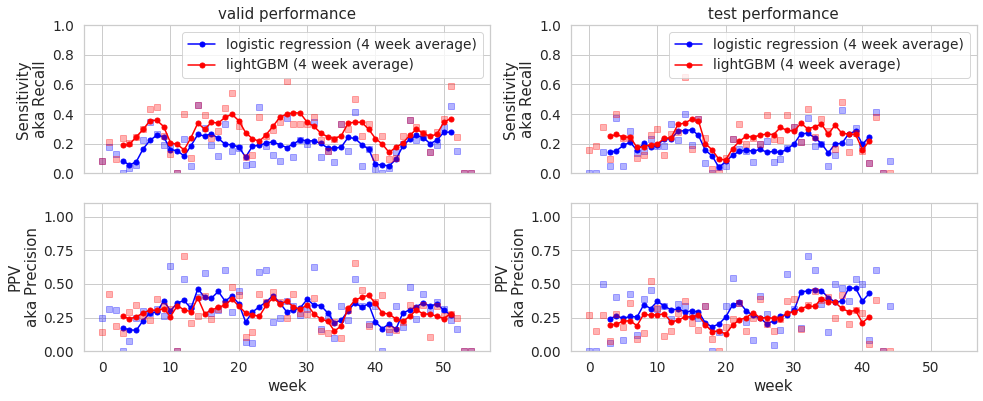

In [28]:
# thresh_map = {'MLP 1 layer (BCE + thr search)' : 0.66,
#               'MLP 1 layer (Hinge Bound)' : 0.73,
#               'MLP 1 layer (Sigmoid Bound)' : 0.25}


ylim_by_metric = dict(
    PPV=(0.0, 1.1),
    NPV=(0.9, 1.0),
    Specificity=(0.0, 1.0),
    Sensitivity=(0.0, 1.0),
    )

target_percentile = '60.0'
f, axgrid = plt.subplots(nrows=2, ncols=2, figsize=(16, 6), sharex=True, sharey=False)
for model in models_dict.keys():

    for ss, split in enumerate(['valid', 'test']):
        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s' and target_percentile == '%s'" % (model, split, target_percentile))
        thresh = cur_perf_df['thresh'].values[0]
#         thresh = thresh_map[model]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh_G = cur_huf_df['threshold_grid'].values[0]
#         thresh_G = (thresh_G - min(thresh_G))/(max(thresh_G)-min(thresh_G))
        
        orig_id = np.searchsorted(thresh_G, thresh)
        
        perf_W_by_key = dict()
        for key in ['TN', 'FP', 'FN', 'TP']:
            perf_W_by_key[key] = cur_huf_df[key + "_arr"].values[0][:,orig_id]
            
        ppv_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FP'])
        npv_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FN'])
        
        target_prec = .25
        frac_w_reaching_constraint = np.sum(ppv_W>target_prec)/len(ppv_W)
        
        recall1_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FN'])
        recall0_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FP'])
        
        ts_W = np.arange(ppv_W.size)
        for aa, (label, arr_W) in enumerate([
                ('Sensitivity\naka Recall', recall1_W), 
            ('PPV\naka Precision', ppv_W), 
#             ('Specificity', recall0_W), 
#             ('NPV', npv_W)
        ]):
            ax = axgrid[aa, ss]
            ax.plot(ts_W, arr_W, 's', 
                    color=color_map[model], #'#666666', 
                    alpha=0.3)
            ax.plot(
                ts_W[3:-3], np.convolve(arr_W, 0.25 * np.ones(4), mode='same')[3:-3],
                '.-', color=color_map[model], markersize=10, label='%s (4 week average)'%model)
            ax.set_ylabel(label)
            ax.set_ylim(ylim_by_metric[label.split('\n')[0]])
        
        axgrid[-1,ss].set_xlabel('week')
        print('model=%s, split=%s, fraction of weeks reaching %.2f precision = %.4f'%(model, split, target_prec,
                                                                                     frac_w_reaching_constraint))
        axgrid[0,ss].set_title("%s performance" % (split))
        axgrid[0,ss].legend()

# f.savefig('temporal_precision_recall_HIL.pdf', bbox_inches='tight', pad_inches=0)

# Confusion matrices

In [73]:
for model in models_dict.keys():
    for ss, split in enumerate(['valid', 'test']):

        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh = cur_perf_df['thresh'].values[0]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        orig_id = np.searchsorted(cur_huf_df['threshold_grid'].values[0], thresh)
        
        row_dict_list = list()
        
        conf_mat_22 = np.zeros((2,2), dtype=np.int32)
        for kk, key in enumerate(['TN_arr', 'FP_arr']):
            count = cur_huf_df[key].values[0][:, orig_id].sum()
            conf_mat_22[0, kk] = count
        for kk, key in enumerate(['FN_arr', 'TP_arr']):
            count = cur_huf_df[key].values[0][:, orig_id].sum()
            conf_mat_22[1, kk] = count

        def make_cm_df_from_arr(arr_22):
            cm_df = pd.DataFrame(arr_22, columns=[0,1], index=[0,1])
            cm_df.columns.name = 'Predicted label'
            cm_df.index.name = 'True label'        
            return cm_df
            
        pd.set_option('precision', 3)
        print("========================== %s %s" % (split.upper(), model))
        print(make_cm_df_from_arr(conf_mat_22))
        print()
        
        for axis in [0, 1]:
            normed_22 = conf_mat_22 / conf_mat_22.sum(axis=axis, keepdims=1)
            print(make_cm_df_from_arr(normed_22))
            print()

========================== VALID lightGBM
Predicted label       0   1
True label                 
0                202250  10
1                  1168  13

Predicted label      0      1
True label                   
0                0.994  0.435
1                0.006  0.565

Predicted label      0          1
True label                       
0                1.000  4.944e-05
1                0.989  1.101e-02

========================== TEST lightGBM
Predicted label       0   1
True label                 
0                122343  14
1                   617  10

Predicted label      0      1
True label                   
0                0.995  0.583
1                0.005  0.417

Predicted label      0          1
True label                       
0                1.000  1.144e-04
1                0.984  1.595e-02

========================== VALID MLP 2 layer
Predicted label       0    1
True label                  
0                201962  298
1                   966  215

Predicted lab

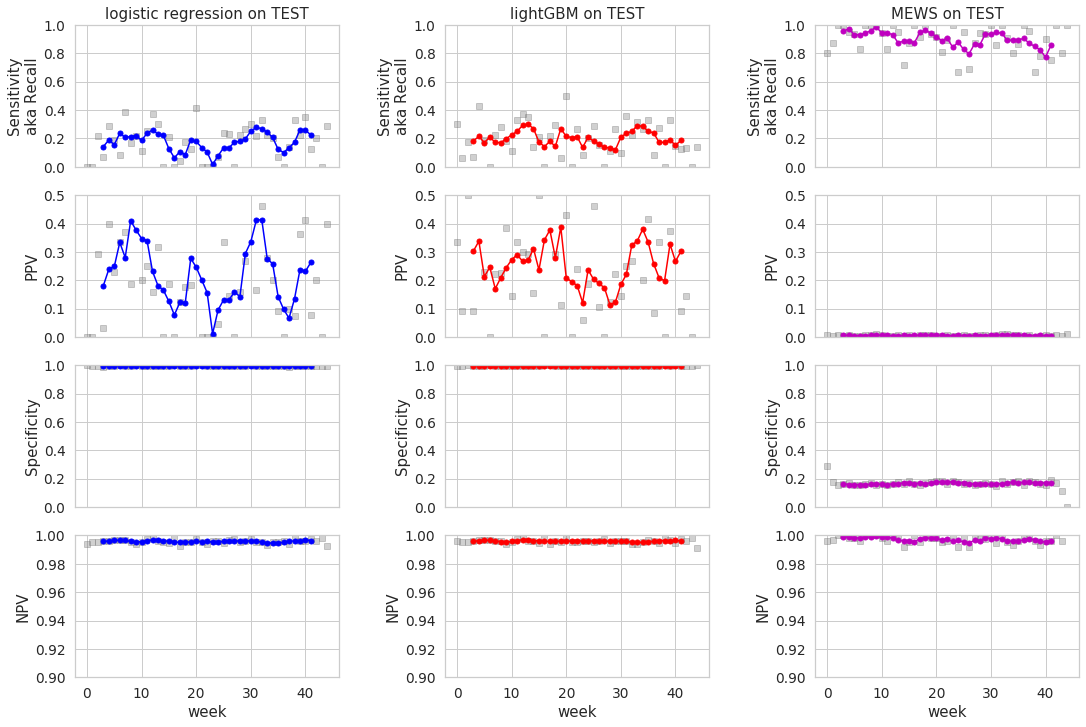

In [15]:
ylim_by_metric = dict(
    PPV=(0.0, 0.5),
    NPV=(0.9, 1.0),
    Specificity=(0.0, 1.0),
    Sensitivity=(0.0, 1.0),
    )

f, axgrid = plt.subplots(nrows=4, ncols=3, figsize=(18, 12), sharex=True, sharey=False)
for mm, model in enumerate(models_dict.keys()):

    for ss, split in enumerate(['test']):
        cur_perf_df = all_perf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        thresh = cur_perf_df['thresh'].values[0]
        
        cur_huf_df = huf_df.query(
            "model == '%s' and split == '%s'" % (model, split))
        orig_id = np.searchsorted(cur_huf_df['threshold_grid'].values[0], thresh)
        
        perf_W_by_key = dict()
        for key in ['TN', 'FP', 'FN', 'TP']:
            perf_W_by_key[key] = cur_huf_df[key + "_arr"].values[0][:,orig_id]
            
        ppv_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FP'])
        npv_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FN'])

        recall1_W = perf_W_by_key['TP'] / (1e-10 + perf_W_by_key['TP'] + perf_W_by_key['FN'])
        recall0_W = perf_W_by_key['TN'] / (1e-10 + perf_W_by_key['TN'] + perf_W_by_key['FP'])
        
        ts_W = np.arange(ppv_W.size)
        for aa, (label, arr_W) in enumerate([
                ('Sensitivity\naka Recall', recall1_W), ('PPV', ppv_W), ('Specificity', recall0_W), ('NPV', npv_W)]):
            ax = axgrid[aa, mm]
            ax.plot(ts_W, arr_W, 's', color='#666666', alpha=0.3, label='raw')
            ax.plot(
                ts_W[3:-3], np.convolve(arr_W, 0.25 * np.ones(4), mode='same')[3:-3],
                '.-', color=color_map[model], markersize=10, label='4 week average')
            ax.set_ylabel(label)
            ax.set_ylim(ylim_by_metric[label.split('\n')[0]])
        
        axgrid[-1, mm].set_xlabel('week')
        axgrid[0, mm].set_title("%s on %s" % (model, split.upper()))
        plt.subplots_adjust(wspace=0.4);
        
# f.savefig('performance_over_weeks_with_med_orders.png', bbox_inches='tight', pad_inches=0)